## Exploration of methodologies
Compilation of different techniques to characterize manipulate time-series.
>_Note:_ In this notebook we explored the methods in dummy time-series, for a more complete and realistic assessment of the methodology, visit the dedicated notebook per methodology.

#### Methods
- [Euclidean distance](#euclidean-distance)
- [Dynamic Time warping (DTW)](#dynamic-time-warping-dtw)
- [Signal processing](#signal-processing)
- [Lomb-Scargle periodogram](#lomb-scargle-periodogram)
- [FFT Spectra](#fft-spectra)
- [Time-series encoder + distance in latent space](#ts-encoder--distance-in-latent-space)
- [Peaks in time-series](#peaks)

## Load data

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('../../data/4_time_series.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
times = loaded_data['times']
series = loaded_data['series']

## Methods

### Euclidean distance

In [13]:
corr = np.correlate(series['s1'], series['s2'], mode='full')  # normalized cross-correlation is auto if series are z-normalized
lag = np.argmax(corr) - (len(series['s1'])-1)

In [18]:
# cannot calculate euclidean distance directly because the time series have different lengths
print(len(series['s1']))
print(len(series['s2']))
print(f"{np.shape(corr)=}")

260
16582
np.shape(corr)=(16841,)


### Dynamic Time warping (DTW)
We calculate the distance directly on the full time series.
The commutativity of the method and implementation was checked.

**Resources**
- [Youtube video series](https://www.youtube.com/watch?v=ERKDHZyZDwA)
- [Blogpost inspired on youtube video series: Dynamic Time Warping. An introduction](https://medium.com/@markstent/dynamic-time-warping-a8c5027defb6)

In [3]:
from tslearn.metrics import dtw

/home/luisa/micromamba/envs/ts/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
dist_1_2 = dtw(series['s1'], series['s2'])
dist_1_3 = dtw(series['s1'], series['s3'])
dist_2_3 = dtw(series['s2'], series['s3'])
dist_3_4 = dtw(series['s3'], series['s4'])
dist_1_1 = dtw(series['s1'], series['s1'])
dist_2_2 = dtw(series['s2'], series['s2'])
dist_3_3 = dtw(series['s3'], series['s3'])
print(f"DTW distance s1 - s2: {dist_1_2}")
print(f"DTW distance s1 - s3: {dist_1_3}")
print(f"DTW distance s2 - s3: {dist_2_3}")
print(f"DTW distance s3 - s4: {dist_3_4}")
# Sanity check:
print(f"DTW distance s1 - s1: {dist_1_1}")
print(f"DTW distance s2 - s2: {dist_2_2}")
print(f"DTW distance s3 - s3: {dist_3_3}")

DTW distance s1 - s2: 24.851714516270054
DTW distance s1 - s3: 11.16297025005938
DTW distance s2 - s3: 44.33664049289935
DTW distance s3 - s4: 6.951306337796141
DTW distance s1 - s1: 0.0
DTW distance s2 - s2: 0.0
DTW distance s3 - s3: 0.0


`tslearn` also allows to calculate the minimum similarity score between a subsequence and the full time sereis (i.e. template matching). This can be useful to search matches of partial data.
For example, we know that `s4` is a bro time-series that is a subset (i.e is contained) in `s3` (DINO sample).
In this case the distance is not 0.0 becuase there are small differences in the signal amplitude (y-axis) in spite of the normalization.

In [15]:
from tslearn.metrics import dtw_subsequence_path
path, dist = dtw_subsequence_path(series['s4'], series['s3'])
print(f"DTW subsequence (s4 bro) distance to s3: {dist}")
print(f"DTW subsequence (s4 bro) normalized  distance to s3: {dist/len(path)}")

DTW subsequence (s4 bro) distance to s3: 1.3045181919731679
DTW subsequence (s4 bro) normalized  distance to s3: 0.01154440877852361


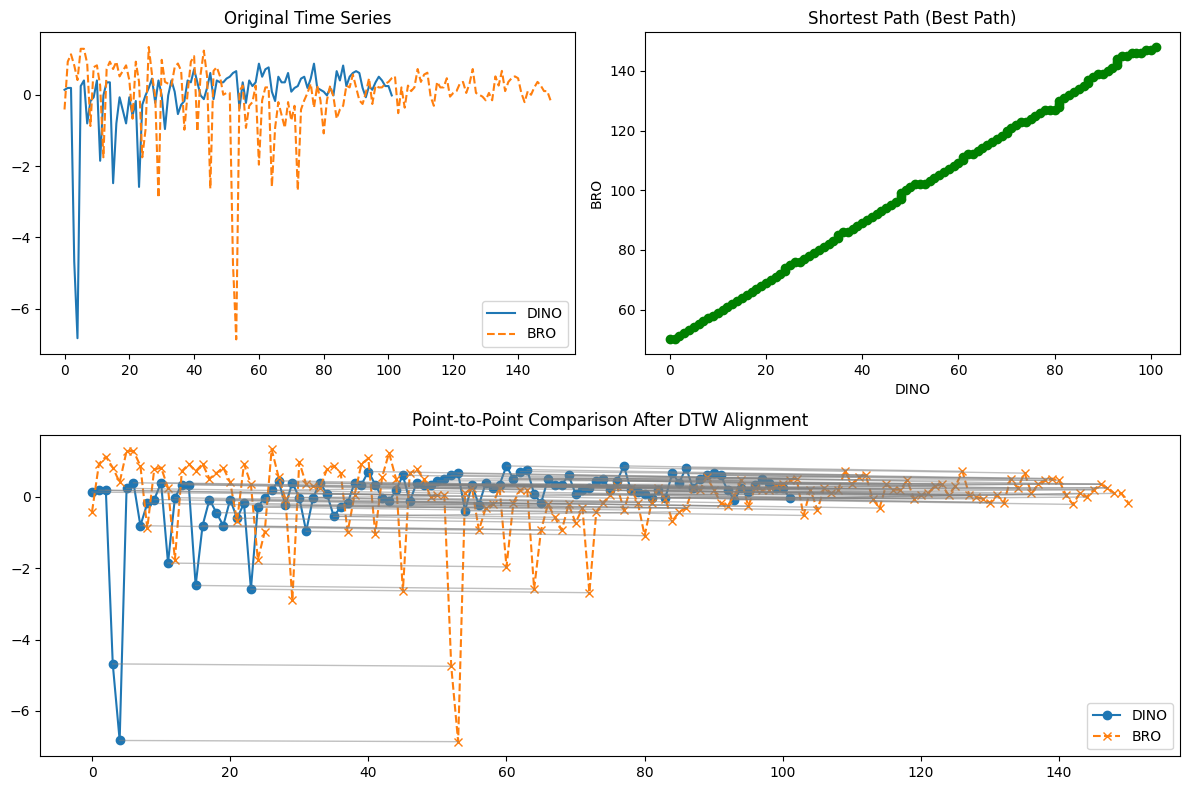

In [ ]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(series['s4'], label='DINO')
ax1.plot(series['s3'], label='BRO', linestyle='--')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(path)[:, 0], np.array(path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('DINO')
ax2.set_ylabel('BRO')

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(series['s4'], label='DINO', marker='o')
ax3.plot(series['s3'], label='BRO', marker='x', linestyle='--')
for a, b in path:
    ax3.plot([a, b], [series['s4'][a], series['s3'][b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

In [13]:
path, dist = dtw_subsequence_path(series['s4'][10:20], series['s4'])
print(f"DTW subsequence s4-subset to s4: {dist}")

DTW subsequence s4-subset to s4: 0.0


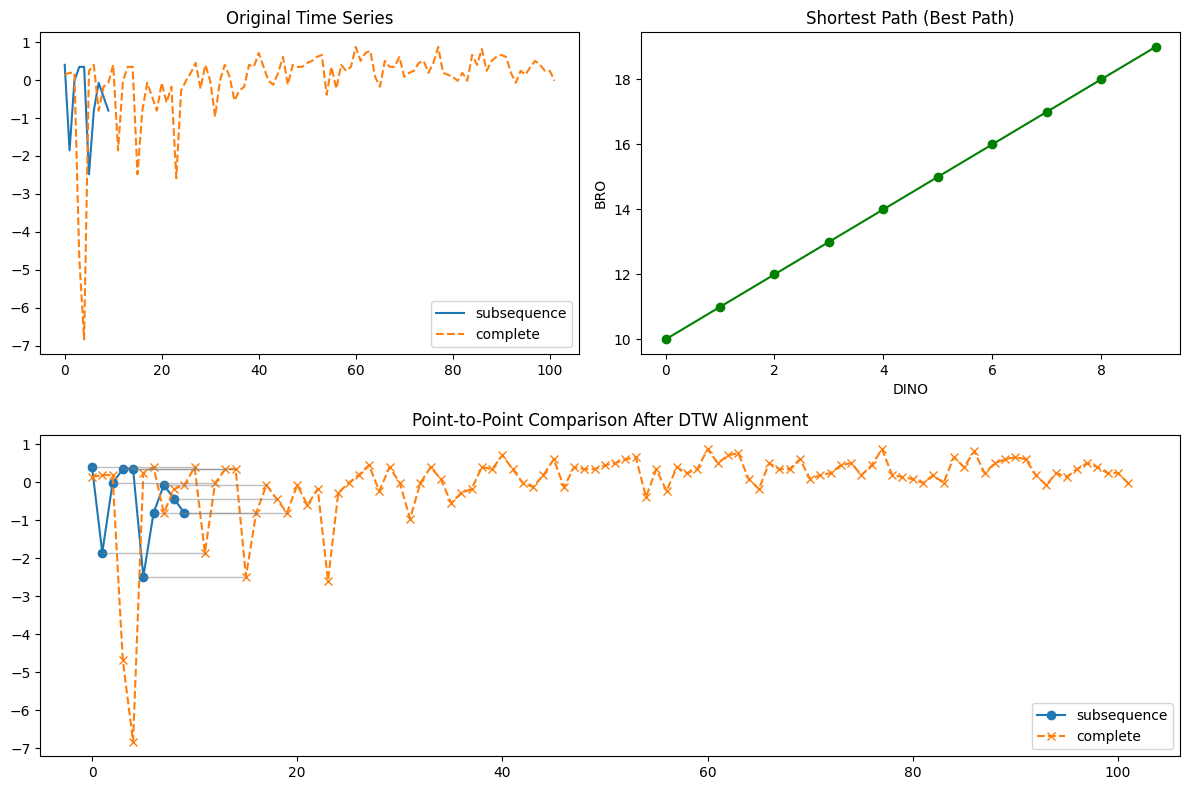

In [14]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(series['s4'][10:20], label='subsequence')
ax1.plot(series['s4'], label='complete', linestyle='--')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(path)[:, 0], np.array(path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('DINO')
ax2.set_ylabel('BRO')

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(series['s4'][10:20], label='subsequence', marker='o')
ax3.plot(series['s4'], label='complete', marker='x', linestyle='--')
for a, b in path:
    ax3.plot([a, b], [series['s4'][10:20][a], series['s4'][b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

### Signal processing

In [ ]:
from scipy.signal import detrend, savgol_filter

In [33]:
detrended_series = {}
smoothed_series = {}
for name, data in series.items():
    detrended_series[name] = detrend(data)
    smoothed_series[name] = savgol_filter(data, 6, 2)

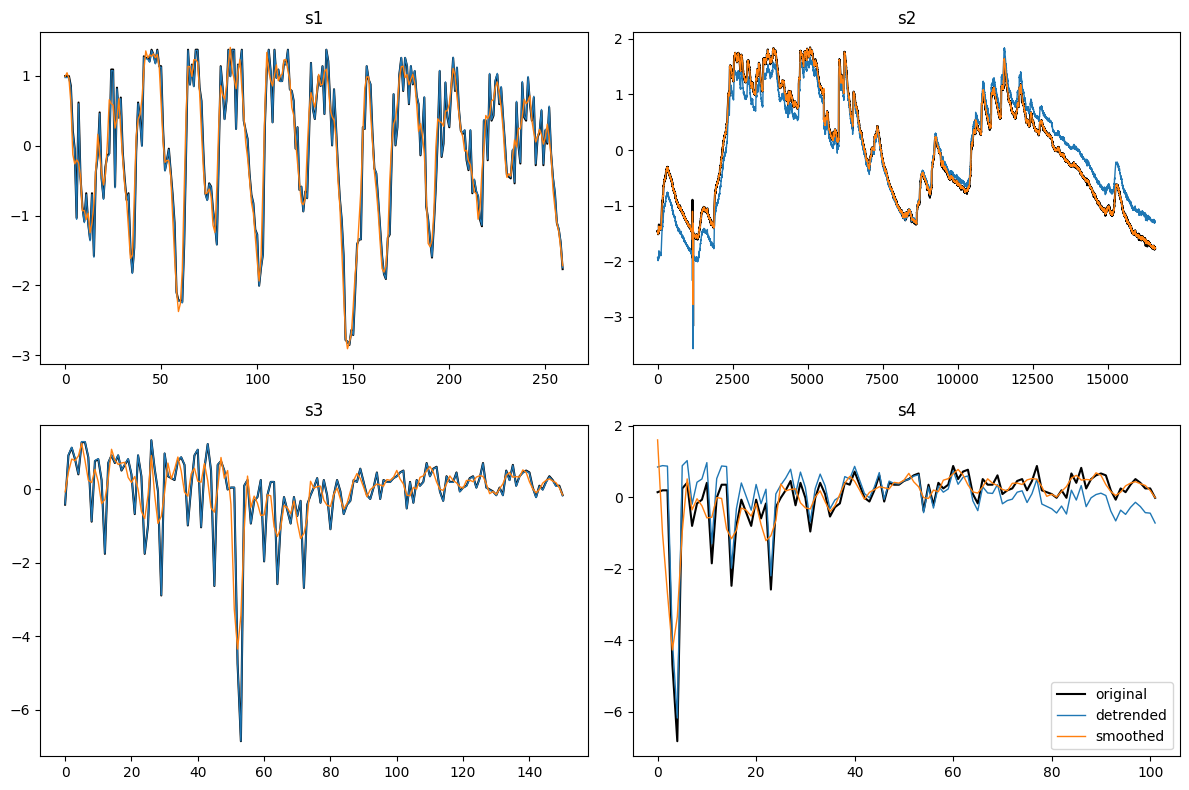

In [34]:
plt.figure(figsize=(12, 8))
for i, name in enumerate(series.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot(series[name], label='original', color='k')
    plt.plot(detrended_series[name], label='detrended', lw=1)
    plt.plot(smoothed_series[name], label='smoothed',lw=1)
    plt.title(f'{name}')
plt.legend()
plt.tight_layout()

###  Lomb-Scargle periodogram

Serie s1 Peak 3: period = 367.0 days, power = 55.495, normalized power: 0.048
Serie s1 Peak 2: period = 785.2 days, power = 8.317, normalized power: 0.007
Serie s1 Peak 1: period = 1051.4 days, power = 5.680, normalized power: 0.005
Serie s2 Peak 2: period = 349.7 days, power = 4645.959, normalized power: 0.011
Serie s2 Peak 3: period = 212.1 days, power = 2086.994, normalized power: 0.005
Serie s2 Peak 1: period = 899.0 days, power = 1945.463, normalized power: 0.005


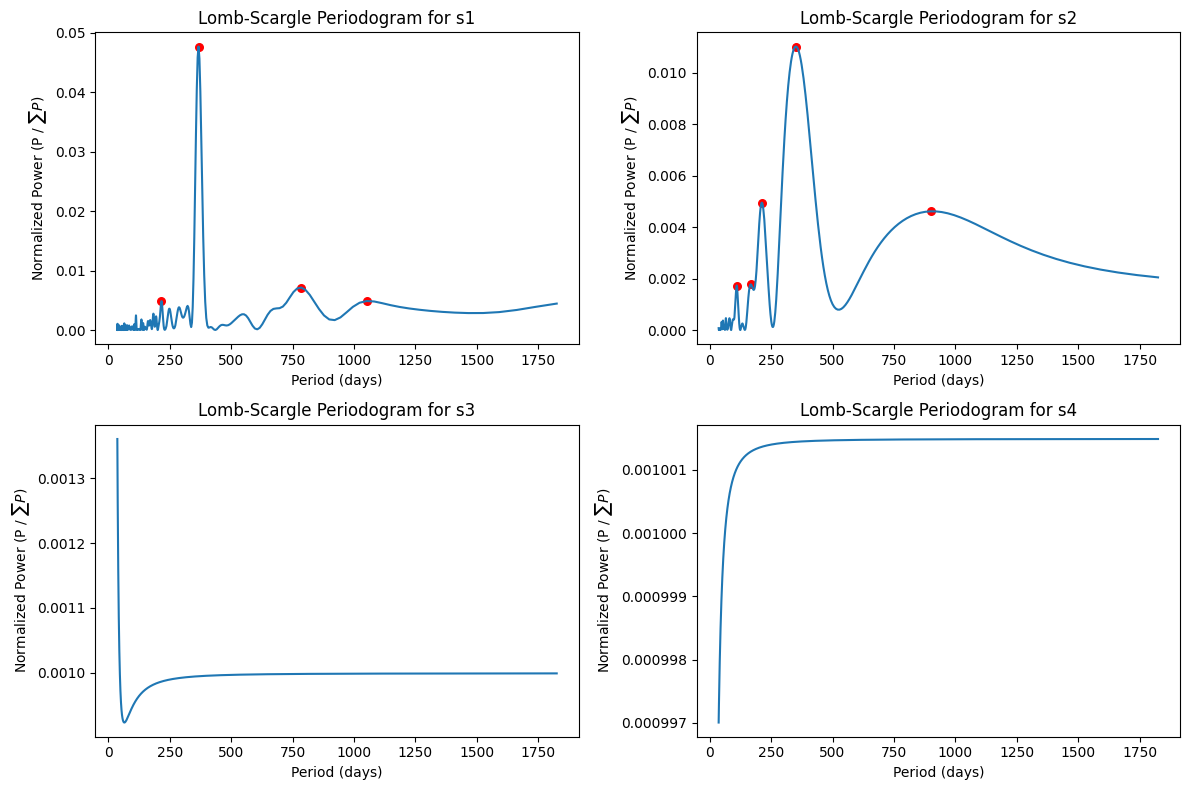

In [22]:
from scipy.signal import lombscargle, find_peaks
plt.figure(figsize=(12, 8))
for i, name in enumerate(series.keys()):
    t = (np.array(times[name]) - times[name][0]) / 1000 / 86400  # convert to days, start at 0
    #freq = np.linspace(0.0001, 0.01, 500)  # roughly 0.036–3.65 cycles/year
    freq = np.linspace(0.2/365, 10/365, 1000) #(cycles per day)
    pgram = lombscargle(t, series[name], 2*np.pi*freq)
    p_norm = pgram / np.sum(pgram)
    # Peak detection
    peaks, _ = find_peaks(pgram, height=np.max(pgram)*0.1)  # peaks higher than 10% of max
    peak_periods = 1 / freq[peaks]
    order = np.argsort(pgram[peaks])[::-1]
    for j in order[:3]:
        print(f"Serie {name} Peak {j+1}: period = {peak_periods[j]:.1f} days, power = {pgram[peaks[j]]:.3f}, normalized power: {p_norm[peaks[j]]:.3f}")

    plt.subplot(2, 2, i+1)
    plt.scatter(peak_periods, p_norm[peaks], color='r', s=30, label='peaks')
    plt.plot(1/freq, p_norm)
    plt.title(f'Lomb-Scargle Periodogram for {name}')
    plt.xlabel('Period (days)')
    plt.ylabel('Normalized Power (P / $\\sum{P}$)')
plt.tight_layout()

**Interpretation**
- `s1`
Strongest peak at 367.5 days (clear year cycle)
- `s2`
Strongest peak at 350.9 days (clear year cycle)
- `s3` and `s4`: no seasonality detected

**Notes**
- Power: how strongly a sine wave of that frequency fits the time-serie.
- Absolute power depends on amplitude, units, sample size, etc.
- Compare power ratios or normalized values, not raw heights (power).

## FFT Spectra
It might be interesting to look at how the spectra of the time series looks like.
Spectra might be biased and not adequeate in this case mainly because:
- Time series shave different sampling rates (ranging from mintues to several days)
- Lenght of sequences can be drastically different.

In this case the frequency, would not be comparable, it might be more sueful to compare the power spectral density (PSD).

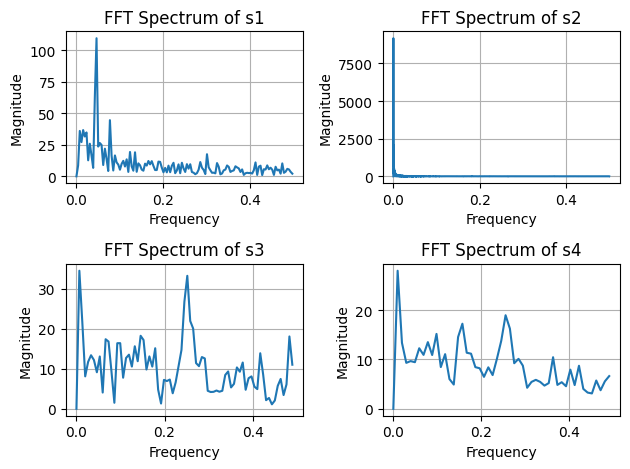

In [43]:
for i, (name, data) in enumerate(series.items()):
    # Compute FFT
    fft_result = np.fft.fft(data)
    magnitude = np.abs(fft_result)
    # Frequency axis (assuming sampling rate of 1)
    freq = np.fft.fftfreq(len(data), d=1)
    
    # Plot only positive frequencies up to Nyquist
    pos_freq = freq[:len(freq)//2]
    pos_magnitude = magnitude[:len(magnitude)//2]
    
    plt.subplot(2, 2, i+1)
    plt.plot(pos_freq, pos_magnitude)
    plt.title(f'FFT Spectrum of {name}')
    plt.xlabel('Frequency'); plt.ylabel('Magnitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

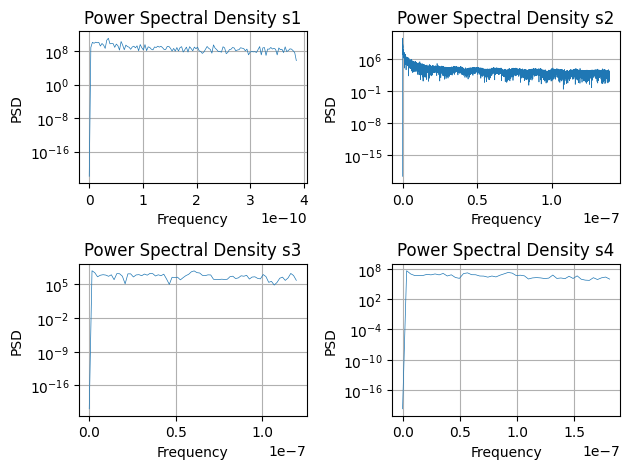

In [44]:
psd = {}
# Power spectral density
for i, (name, x) in enumerate(series.items()):
    N = len(x)
    #w = np.hanning(N)
    t = times[name]
    fs = 1.0 / np.median(np.diff(t)) # replace with real query to the time axis
    #x = x - np.mean(x)
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    #U = (1.0 / N) * np.sum(w**2)      # window power normalization
    Pxx = (1.0 / (fs * N )) * (np.abs(X) ** 2)
    
    # One-sided correction: double all bins except DC and Nyquist
    if N % 2 == 0:
        Pxx[1:-1] *= 2.0
    else:
        Pxx[1:] *= 2.0
    psd[name] = [freqs, Pxx]

    plt.subplot(2, 2, i+1)
    plt.semilogy(freqs, Pxx, lw=0.5)
    plt.title(f'Power Spectral Density {name}')
    plt.xlabel('Frequency'); plt.ylabel('PSD')
    plt.grid(True)
plt.tight_layout()

In [ ]:
def psd_fingerprint(freqs, Pxx, n_bands=24, fmin=None, fmax=None,
                    log_scale=True, norm='l2', eps=1e-12):
    """
    Compress PSD into n_bands of integrated power (a fingerprint vector).
    freqs: 1D array of frequencies (>0)
    Pxx:   1D PSD (non-negative)
    n_bands: number of bands to integrate
    fmin/fmax: common range for comparability; if None, uses data range
    log_scale: log-spaced bands (good for wide ranges); else linear
    norm: 'l2' | 'sum' | None  (how to normalize the fingerprint)
    """
    f = np.asarray(freqs); S = np.asarray(Pxx)
    mask = np.isfinite(f) & np.isfinite(S) & (f > 0) & (S >= 0)
    f, S = f[mask], S[mask]
    order = np.argsort(f); f, S = f[order], S[order]

    fmin = max(f.min(), fmin) if fmin is not None else f.min()
    fmax = min(f.max(), fmax) if fmax is not None else f.max()
    if not np.isfinite(fmin) or not np.isfinite(fmax) or fmax <= fmin:
        raise ValueError("Invalid fmin/fmax after masking.")

    edges = (np.logspace(np.log10(fmin), np.log10(fmax), n_bands+1)
             if log_scale else np.linspace(fmin, fmax, n_bands+1))

    band_power = np.zeros(n_bands, dtype=float)
    for i in range(n_bands):
        a, b = edges[i], edges[i+1]
        m = (f >= a) & (f <= b)
        if m.sum() >= 2:
            band_power[i] = np.trapezoid(S[m], f[m])  # integrate PSD over the band
        elif m.sum() == 1:
            # single point: approximate power as PSD * band width
            band_power[i] = S[m][0] * (b - a)
        # else remains 0 if no samples fall into the band

    # Normalize fingerprint
    if norm == 'sum':
        s = band_power.sum() + eps
        band_power = band_power / s
    elif norm == 'l2':
        n = np.linalg.norm(band_power) + eps
        band_power = band_power / n

    return band_power, edges

In [46]:
# Similarity scores
def cosine_similarity(f1, f2, eps=1e-12):
    return float(np.dot(f1, f2) / (np.linalg.norm(f1)*np.linalg.norm(f2) + eps))

def js_similarity(f1, f2, eps=1e-12):
    # Jensen–Shannon similarity in [0,1]; fingerprints treated as distributions
    p = f1 / (f1.sum() + eps); q = f2 / (f2.sum() + eps)
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*np.log((a+eps)/(b+eps)))
    jsd = 0.5*kl(p,m) + 0.5*kl(q,m)
    return float(1.0 - np.sqrt(jsd / np.log(2)))  # 1=identical, 0=dissimilar


In [47]:
# Pick a **common** frequency range so fingerprints are comparable:
mins, maxs = [], []
for name, (freqs, Pxx) in psd.items():
    f = np.asarray(freqs, float)
    m = np.isfinite(f) & (f > 0)      # use (f >= 0) if you want to include DC
    if m.sum() >= 2:                  # need at least two valid points
        mins.append(f[m].min())
        maxs.append(f[m].max())

if not mins or not maxs:
    raise ValueError("No valid positive frequencies found in any series.")

fmin_common = float(np.max(mins))     # highest of the per-series mins
fmax_common = float(np.min(maxs))     # lowest of the per-series maxs
print(fmin_common, fmax_common)
if fmax_common <= fmin_common:
    raise ValueError("No overlapping frequency range across series.")


3.5459785766158317e-09 3.8580246913580243e-10


ValueError: No overlapping frequency range across series.

In [48]:
fprints = []
for name, (freqs, Pxx) in psd.items():
    fp, _ = psd_fingerprint(freqs, Pxx, n_bands=20,
                            fmin=fmin_common, fmax=fmax_common,
                            log_scale=True, norm='l2')
    fprints.append(fp)

ValueError: Invalid fmin/fmax after masking.

In [ ]:
fprints

In [ ]:
psd_dist_1_2 = cosine_similarity(fprints[0], fprints[1])
psd_dist_1_3 = cosine_similarity(fprints[0], fprints[2])
psd_dist_2_3 = cosine_similarity(fprints[1], fprints[2])
psd_dist_3_4 = cosine_similarity(fprints[2], fprints[3])
psd_dist_1_1 = cosine_similarity(fprints[0], fprints[0])
psd_dist_2_2 = cosine_similarity(fprints[1], fprints[1])

print(f"cosine similarity PSD s1 - s2: {psd_dist_1_2}")
print(f"cosine similarity PSD s1 - s3: {psd_dist_1_3}")
print(f"cosine similarity PSD s2 - s3: {psd_dist_2_3}")
print(f"cosine similarity PSD s3 - s4: {psd_dist_3_4}")
# Sanity check:
print(f"cosine similarity PSD s1 - s1: {psd_dist_1_1}")
print(f"cosine similarity PSD s2 - s2: {psd_dist_2_2}")


In [ ]:
psd_js_sim_1_2 = js_similarity(fprints[0], fprints[1])
psd_js_sim_1_3 = js_similarity(fprints[0], fprints[2])
psd_js_sim_2_3 = js_similarity(fprints[1], fprints[2])
psd_js_sim_3_4 = js_similarity(fprints[2], fprints[3])
psd_js_sim_1_1 = js_similarity(fprints[0], fprints[0])
psd_js_sim_2_2 = js_similarity(fprints[1], fprints[1])

print(f"js similarity PSD s1 - s2: {psd_js_sim_1_2}")
print(f"js similarity PSD s1 - s3: {psd_js_sim_1_3}")
print(f"js similarity PSD s2 - s3: {psd_js_sim_2_3}")
print(f"js similarity PSD s3 - s4: {psd_js_sim_3_4}")
# Sanity check:
print(f"js similarity PSD s1 - s1: {psd_js_sim_1_1}")
print(f"js similarity PSD s2 - s2: {psd_js_sim_2_2}")

## TS Encoder + distance in latent space

#### granite-TSFM (IBM)
> See a more developed version of this exploration in [tspulse_test](tspulse_test.ipynb)

Following this [notebook](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/tspulse_search_simple_example.ipynb), we are going to:
1. Load a model (already trained) [ibm-granite/granite-timeseries-tspulse-r1](https://huggingface.co/ibm-granite/granite-timeseries-tspulse-r1)
2. Convert the time-series to windows of size 512 (because model is defined with this input size)
3. Calculate the embeddings of our data (windows of time series)
4. We can calculate the cosine distance between the embeddings of the different windows.

In [ ]:
import torch
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from transformers import set_seed

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.models.tspulse.utils.helpers import get_embeddings

In [50]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=1,
    mask_type="user",
)
model.eval()

TSPulseForReconstruction(
  (loss): MSELoss()
  (backbone): TSPulseModel(
    (encoder_block): TSPulseBlock(
      (mixers): ModuleList(
        (0-7): 8 x TSPulseLayer(
          (patch_mixer): PatchMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            )
            (mlp): TSPulseMLP(
              (fc1): Linear(in_features=138, out_features=276, bias=True)
              (dropout1): Dropout(p=0.2, inplace=False)
              (fc2): Linear(in_features=276, out_features=138, bias=True)
              (dropout2): Dropout(p=0.2, inplace=False)
            )
            (gating_block): TSPulseGatedAttention(
              (attn_layer): Linear(in_features=138, out_features=138, bias=True)
              (attn_activation_layer): Softmax(dim=-1)
            )
          )
          (feature_mixer): FeatureMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwi

In [52]:
s1_t = torch.tensor(series['s1'], dtype=torch.float)

In [ ]:
win = 512 # context, fixed for the model trained.
mini_series = []

for name, arr in series.items():
    print(f"len({name}): {len(arr)}")
    x = np.asarray(arr, dtype=float)
    for i in range(0, len(x) - win + 1, win):
        w = x[i:i+win]
        if len(w) == win:
            mini_series.append(torch.tensor(w, dtype=torch.float32).unsqueeze(1))  # shape (win, 1)

X = torch.stack(mini_series)  # shape (n, win, 1)
print('Shape of X:', X.shape)

len(s1): 260
len(s2): 16582
len(s3): 151
len(s4): 102
Shape of X: torch.Size([32, 512, 1])


Because of the small size of out time-series, we are only considering the second one `s2` that is long enough to fit 32 windows of size 512.

In [54]:
with torch.no_grad():
    embs = get_embeddings(model, X, mode="register")

In [55]:
embs.shape

torch.Size([32, 1, 240])

### Peaks

In [ ]:
def find_peaks_1d(x, neighborhood=1, prom_window=50, min_prominence=0.0, top_k=None):
    """
    Simple peak picker (pure numpy).
    - x: 1D array
    - neighborhood: number of samples on each side a value must exceed to be considered a local max
    - prom_window: search radius to compute a crude prominence (in samples)
    - min_prominence: minimum prominence (peak - max(base_left, base_right))
    - top_k: keep only top_k peaks by magnitude (per call)
    Returns: list of (idx, value, prominence) sorted by idx
    Notes: O(n * neighborhood) which is fine for small neighborhood (e.g. 3..31).
    """
    n = len(x)
    if n == 0:
        return []

    # don't consider edges where neighborhood would go out of bounds
    lo = neighborhood
    hi = n - neighborhood
    candidates = []
    for i in range(lo, hi):
        window = x[i-neighborhood : i+neighborhood+1]
        # is x[i] strictly greater than others in window (tie-breaking: allow equality on right)
        center = window[neighborhood]
        if center <= np.max(np.delete(window, neighborhood)): continue
        # compute crude prominence: drop to highest base on left/right within prom_window
        left_start = max(0, i - prom_window)
        right_end = min(n, i + prom_window + 1)
        # left base: minimal value between i and nearest higher (approx by min)
        left_min = np.min(x[left_start:i]) if i - left_start > 0 else center
        right_min = np.min(x[i+1:right_end]) if right_end - (i+1) > 0 else center
        base = max(left_min, right_min)
        prominence = center - base
        if prominence >= min_prominence:
            candidates.append((i, center, prominence))

    if not candidates:
        return []

    # optionally keep top_k by magnitude
    if top_k is not None and len(candidates) > top_k:
        candidates.sort(key=lambda t: t[1], reverse=True)
        candidates = candidates[:top_k]
        candidates.sort(key=lambda t: t[0])  # sort back by time

    return candidates

def find_time_peaks(series, smooth_windows=(11,31,91), prominence=0.5, top_k_per_scale=50):
    peaks = []
    for scale_idx, w in enumerate(smooth_windows):
        w = int(w) if int(w) % 2 == 1 else int(w) + 1
        s_s = savgol_filter(series, w, polyorder=3)
        raw_peaks = find_peaks_1d(s_s, neighborhood=max(1, w//8),
                                  prom_window=w*2, min_prominence=prominence,
                                  top_k=top_k_per_scale)
        for idx, val, prom in raw_peaks:
            peaks.append((int(idx), int(scale_idx), float(val)))
    peaks.sort(key=lambda x: x[0])
    return peaks

In [ ]:
peaks = find_time_peaks(series['s1'], smooth_windows=(5,7,15), prominence=0.05, top_k_per_scale=10)

[(42, 0, 1.3768173700208948), (43, 1, 1.3788433619627454), (45, 0, 1.320764926296385), (46, 1, 1.3079336439980043), (46, 2, 1.419531269512873), (48, 1, 1.3180636037072526), (49, 0, 1.2930763697577714), (65, 0, 1.229595288913146), (66, 1, 1.1514820440440507), (67, 2, 1.2788883145752636), (68, 1, 1.2358983749544574), (69, 0, 1.296453022994188), (86, 1, 1.347327931756194), (86, 2, 1.1951442585173553), (87, 0, 1.3430508376567323), (89, 2, 1.1379245011853238), (91, 0, 1.3720900554899118), (106, 0, 1.3552067893078306), (106, 1, 1.1818719231717973), (110, 2, 1.2193797669499502), (115, 0, 1.302530998819737), (115, 1, 1.2111362512207382), (115, 2, 1.1481277999693906), (132, 2, 0.9921050298834704), (136, 1, 1.103083347655418), (136, 2, 0.9756770771242179), (137, 0, 1.2322966115022793), (176, 1, 1.2066340469055166), (176, 2, 1.0502873625724891), (179, 2, 1.1138815078241262)]


In [39]:
df_peaks = pd.DataFrame(peaks, columns=['idx', 'scale', 'val']).astype({'idx': int, 'scale': int, 'val': float})
df_peaks = df_peaks.groupby('idx', as_index=False).agg({'val': 'max', 'scale': 'first'})
idxs = df_peaks['idx'].values
peak_vals = series['s1'][idxs]

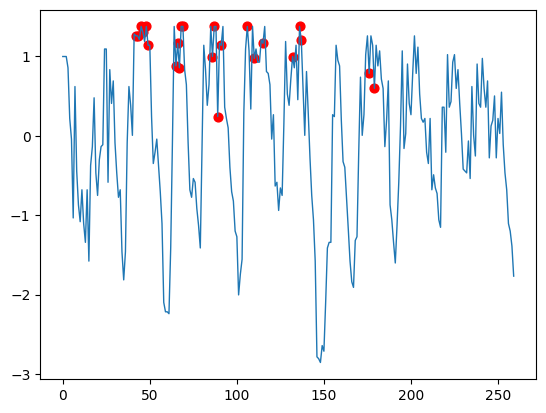

In [41]:
plt.plot(series['s1'], '-', lw=1, label='signal (samples)')
plt.scatter(idxs, peak_vals, c='red', s=40, label='detected peaks')

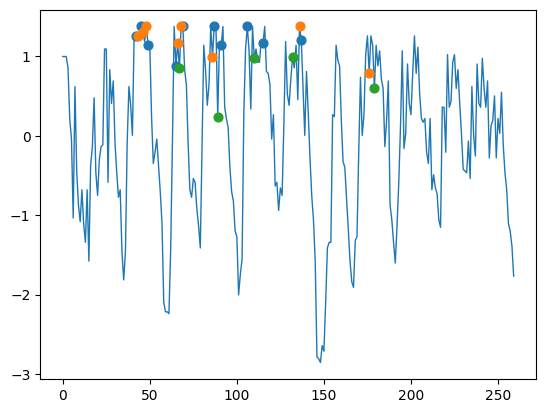

In [42]:
plt.plot(series['s1'], '-', lw=1, label='signal')
scales = sorted(df_peaks['scale'].unique())
cmap = plt.get_cmap('tab10')
color_map = {s: cmap(i % cmap.N) for i, s in enumerate(scales)}
for s in scales: # plot with different color the peaks of different scales `smooth_windows` argument.
    sub = df_peaks[df_peaks['scale'] == s]
    idxs = sub['idx'].values
    vals = series['s1'][idxs]
    plt.scatter(idxs, vals, c=[color_map[s]], s=40, label=f'scale {s}', zorder=5)